# MEDimage Tutorial − Initiation to the MEDimage class

@Author : [MEDomics consortium](https://github.com/medomics/)

@Email : medomics.info@gmail.com


**STATEMENT**:
This file is part of <https://github.com/MEDomics/MEDomicsLab/>,
a package providing PYTHON programming tools for radiomics analysis.
--> Copyright (C) MEDomicsLab consortium.

This package is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This package is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this package.  If not, see <http://www.gnu.org/licenses/>.

## Introduction


This notebook is a tutorial for the *MEDimage* class to give a detailed introduction & explanation on the Python class. The *MEDimage* class is the main object used in the *MEDimage* package either when it comes to processing, features extraction or any other type of image analysis. It offers many attributes, child classes and many methods. This makes the *MEDimage* package an excellent tool for radiomics studies. 

Our *MEDimage* tutorial will guide you to learn everything you need about the *MEDimage* class.


The idea behind the *MEDimage* class was to convert an equivalent of the radiomics study scheme flowchart (Figure below) into a Python object.

<img src="https://ibsi.readthedocs.io/en/latest/_images/Processing_simplifiedv6.png" alt="Flowchart of radiomics study scheme" style="width:650px;"/>

And using the Python new objects (*MEDimage* and its children), we get the following flowchart

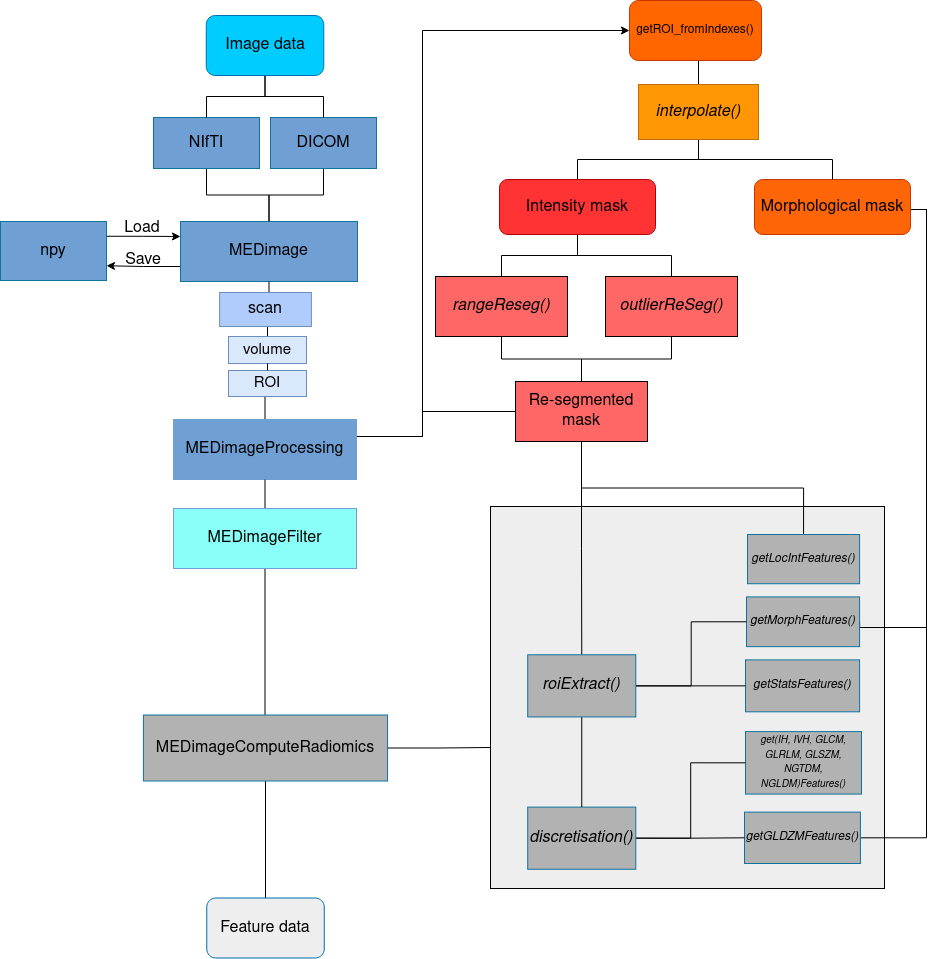

As the figures show, the *MEDimage* class is the main pillar for the *MEDimage* package architecture.

The *MEDimage* class attributes are usually data extracted from imaging data headers (DICOM header, NIfTI header...) and used for processing and computation. In addition to the attributes, the *MEDimage* class contains different class methods that are also used for the same purposes as the attributes. Finally, *MEDimage* have two sub-classes *MEDimageProcessing* and *MEDimageComputeRadiomics*. *MEDimageProcessing* is a class that inherits directly from *MEDimage* and offers many processing methods with different algorithms that are usually called before features extraction. Next, *MEDimageComputeRadiomics* inherits from *MEDimageProcessing* and offers all the computation methods needed for features extraction.

In [1]:
from copy import deepcopy
from pathlib import Path

import os
import sys

MODULE_DIR = os.path.dirname(os.path.abspath('../MEDimage/MEDimage.py'))
sys.path.append(os.path.dirname(MODULE_DIR))

# import MEDimage classes
from MEDimage.MEDimage import MEDimage
from MEDimage.MEDimageComputeRadiomics import MEDimageComputeRadiomics
from MEDimage.MEDimageProcessing import MEDimageProcessing
from MEDimage.utils import jsonUtils

In [2]:
def __processParams(imParams, scanType):
    """
    Process the computation settings.
    
    Args:
        imParams (Dict): JSON with the options that will be used during 
            the image processing and features extraction.
        scanType (str): scan type (Ex: MRscan, CTscan...).
        
    Returns:
        A dict with all the settings for the right scan type.
        
    """
    if scanType == 'MRscan':
        imParams = imParams['imParamMR']
    elif scanType == 'CTscan':
        imParams = imParams['imParamCT']
    elif scanType == 'PTscan':
        imParams = imParams['imParamPET']
    else:
        raise ValueError(r"scanType must be 'MRscan', 'PTscan' or 'CTscan'")
        
    return imParams

In [3]:
def __getPathSave():
    """
    Creates the results folder if not found.
    
    Returns:
        Path: Path to where the results are gonna be saved
    """
    _rp = Path(os.getcwd()) / "data" / "npy"
    if not _rp.exists():
        # creating the directory if it does not exit
        Path.mkdir(_rp, parents=True)
    # return the path to the results folder
    return _rp

## MEDimage initialization

Initializing a *MEDimage* class is easy, as you saw in the class diagram above, the *MEDimage* class can be created from raw data, either DICOM or NIfTI. The DICOM data can be processed and converted to a *MEDimage* class and saved as a [pickle object](https://docs.python.org/3/library/pickle.html) (*npy* format) using the method *processDICOM()* that uses a set DICOM files paths of a multiple scans and calls another method *process_dicom_scan_files()* which creates the *MEDimage* class using a set of DICOM file paths for a given scan. Whereas, for NIfTI files, *MEDimage* class can be directly created using the method *initMEDimage()*. Additionally, you can use this method as well to load an already-saved *MEDimage* instance. In this tuto we will demonstrate both approaches (DICOM & NIfTI), so we we will need DICOM and NIfTI data. The following figure shows the current folder structure:

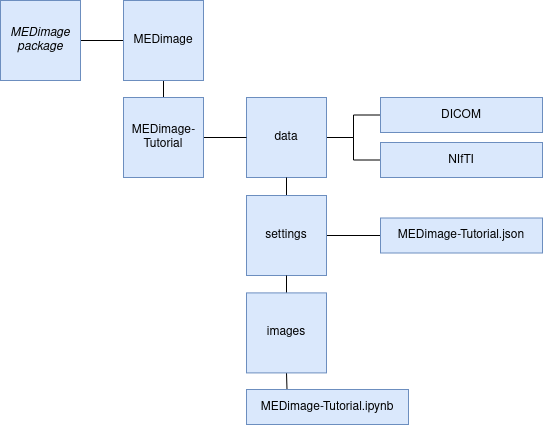

The *data* folder contains data for the same scan: *Glioma-TCGA-02-003*. *DICOM* folder contains multiple dcm files (slices of the imaging volume and files for the RTSTRCUT (Mask data)). The *NIfTI* folder contains files of the imaging and mask data for the same scan as well, the filenames should respect the following naming convention:
   - Imaging volume: **PatientID__ImagingScanName(tumorAuto).ImagingModality.nii.gz**
   - ROI mask: **PatientID__ImagingScanName(tumor).ROI.nii.gz**

We will also need settings for processing and it should be organized in a *JSON* file. A *JSON* file is already available in the *settings* fodler and can the values can be freely changes.

In [4]:
pathSettings = Path(os.getcwd()) / "settings" # Path to the script settings
imParams = jsonUtils.loadjson(pathSettings / 'MEDimage-Tutorial.json') # Processing & computation settings
imParams = __processParams(imParams, scanType='MRscan')

Finally, here some information about our scan/patient:
 - **ID**: Glioma-TCGA-02-003
 - **Imaging scan name**: T1
 - **Modality**: MRscan
 - **Regions of interest**:
     - Number of regions: 3
     - Names of ROIs: ED, ET and NET
     - ROI name: {ED}+{ET}+{NET}

## Initialziation - DICOM

As mentionned before, the *MEDimage* class can be initialized using DICOM raw data. This can be done by calling the method *process_dicom_scan_files()*, this method takes three arguments:
 - pathImages: List of paths to all the DICOM imaging data files (for a single scan)
 - pathRS: List of paths to all the DICOM mask data files (for a single scan)
 - pathSave (optional): path where to save the MEDimage instance.
 
Let's now initialize these varaibles before we call our method

In [5]:
path_dicom_image = Path(os.getcwd()) / "data" / "DICOM" / "Image" # Path to the DICOM imaging data folder
path_dicom_mask = Path(os.getcwd()) / "data" / "DICOM" / "Mask" # Path to the DICOM mask data folder

# extract list of files with dcm extension (files like *.dcm)
path_images = list(path_dicom_image.rglob('*.dcm'))
path_masks = list(path_dicom_mask.rglob('*.dcm'))

And now *path_images* and *path_masks* should have paths to all the DICOM data

In [6]:
print(*path_masks, sep='\n')

/home/local/USHERBROOKE/aitm2302/Bureau/MEDOMICS-ALL/MEDimagePackage/MEDimage/MEDimage-Tutorial/data/DICOM/Mask/2.16.840.1.114362.1.11785856.21988995044.507357457.924.7974.dcm
/home/local/USHERBROOKE/aitm2302/Bureau/MEDOMICS-ALL/MEDimagePackage/MEDimage/MEDimage-Tutorial/data/DICOM/Mask/2.16.840.1.114362.1.11785856.21988995044.507357458.463.8121.dcm


Now that we have the arguments we need, let's call our method

In [7]:
from MEDimage.utils.process_dicom_scan_files import process_dicom_scan_files
import ray
    
if not ray.is_initialized():
    ray.init(local_mode=True, include_dashboard=True)

MEDimg = ray.get(process_dicom_scan_files.remote(path_images, path_masks))

if ray.is_initialized():
    ray.shutdown() 

2022-05-26 13:31:53,769	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


**Extra**: If you would like to initialize *MEDimage* class children as well, it takes two lines of code

In [8]:
# MEDimageProcessing instance
MEDimageProcess = MEDimageProcessing(MEDimg=MEDimg, log_file='a_random_text_file.txt')

# MEDimageComputeRadiomics instance
MEDimageCR = MEDimageComputeRadiomics(MEDimg=MEDimg, log_file='another_random_text_file.txt')

We now should have a *MEDimage*, *MEDimageProcessing* and *MEDimageComputeRadiomics*  class instance saved in workspace.

### Initialization - NIfTI

Using *NIfTI* files, we will need two files, one contains imaging data and the other contains the ROI mask. The two files must be located in *data/NIfTI* then we call the method *initMEDimage()* and finish the *MEDimage* initialization. We will need 4 main arguments for our method:
- nameRead: name of the scan that will be used to initialize the MEDimage class and its children.
- pathRead: Path to the NIfTI imaging volume file.
- roiType: ROI type.
- imParams: Dict of the processing & computation parameters.
- log_file: Name of the logging file that will be used for errors, exceptions...

*initMEDimage()* will initialize and return the *MEDimage* children (using the *MEDimage* saved instance) and that's all we need for our image processing and features processing.

In [9]:
nameReadNifti = 'Glioma-TCGA-02-0003__T1(tumorAuto).MRscan.nii.gz' # scan name
pathReaNifti = Path(os.getcwd()) / "data" / "NIfTI" # NIfTI data path
logFileNifti = 'MEDimageTutoLogFile' # logging file name

Now that we have the arguments we need, let's call our method

In [10]:
from MEDimage.utils.initMEDimage import initMEDimage

MEDimageProcessNifti, MEDimageCRNifti = initMEDimage(nameRead=nameReadNifti, 
                                           pathRead=pathReaNifti, 
                                           roiType='', 
                                           imParams=imParams, 
                                           log_file=logFileNifti)

By now it should be clear to you how to initialize a *MEDimage* class and its children from raw data or from a saved *MEDimage* instance. With that being said, let's understand what's going inside these instances

## MEDimage exploration

We have now initialized *MEDimage* successfully. To further understand the *MEDimage* class and its children, let's take a look at the class diagram below that describes the structure of the *MEDimage* class, its attributes, methods and the relationships among other objects.

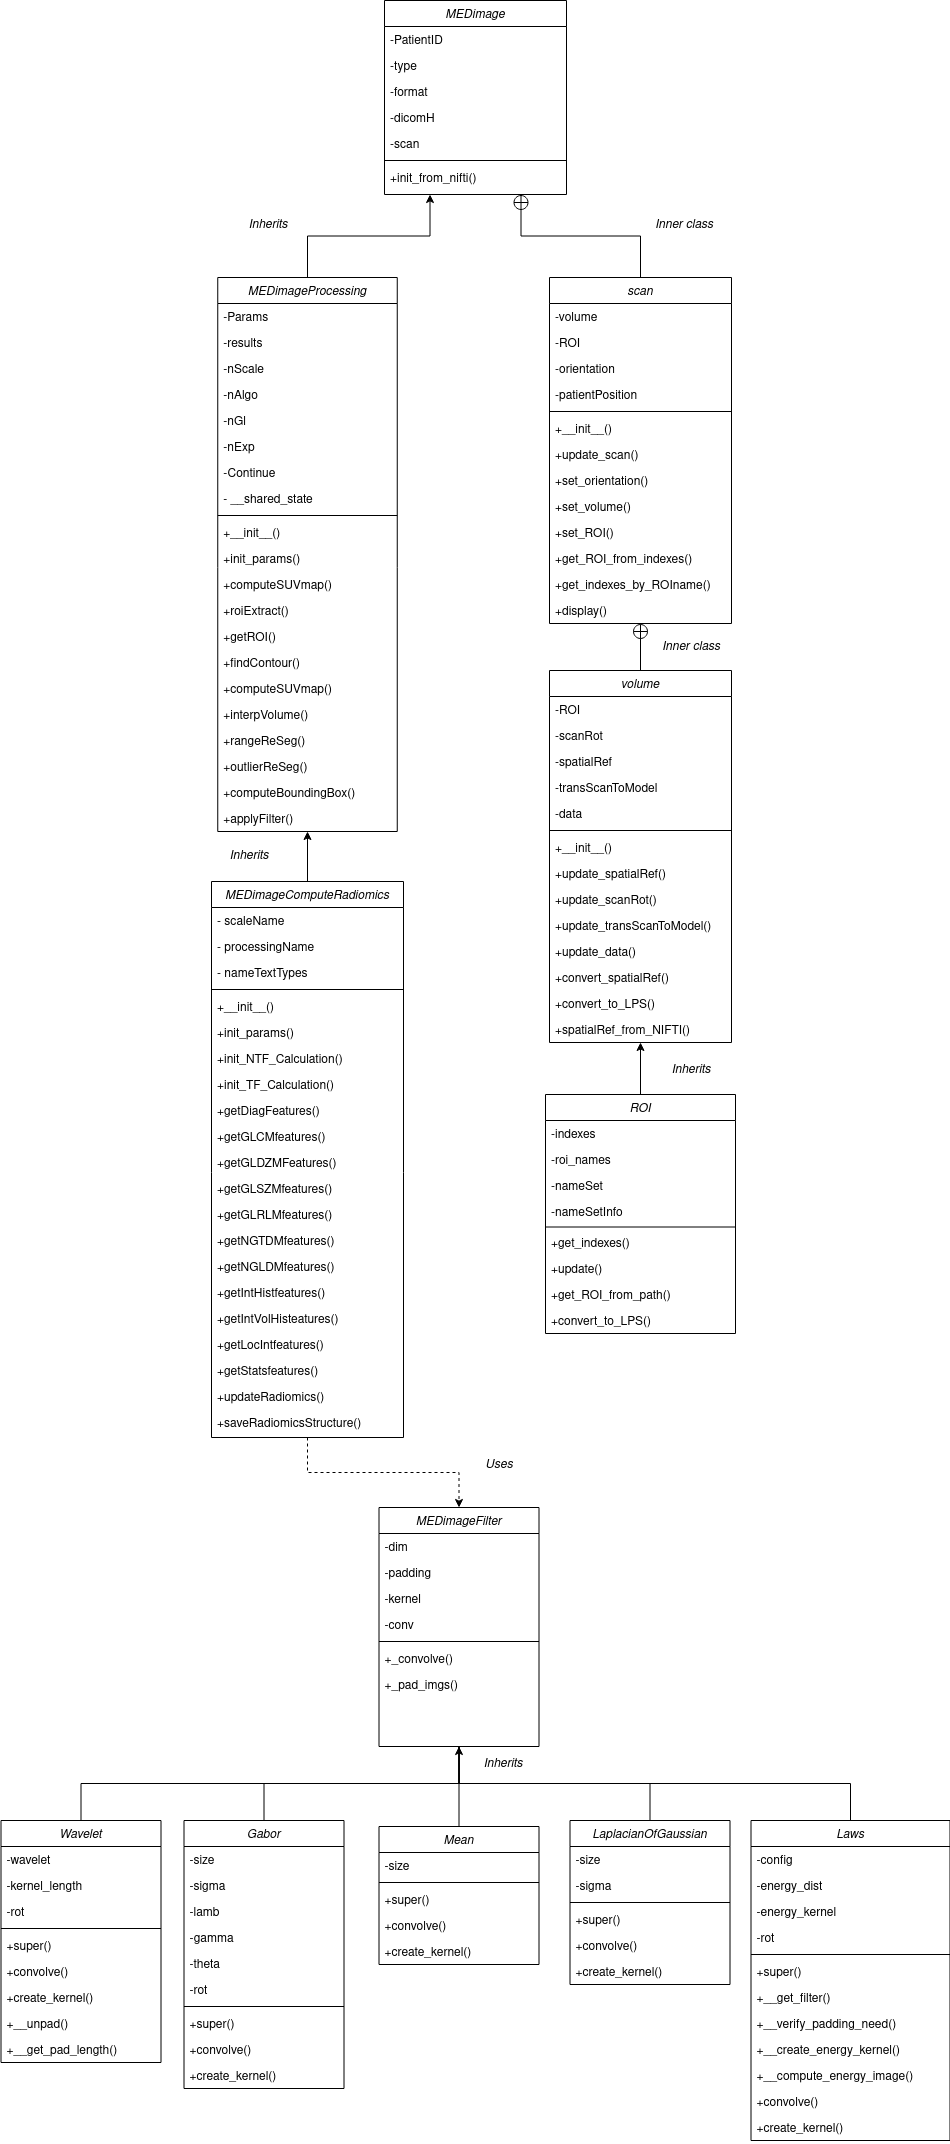

We are going to explore each and every attribute

**PS**: As long as you are using data from the same scan, the format does not changes anything and the *MEDimage* instances will all be the same.

###  - Patient ID
A special identification string for each patient/scan.

In [11]:
MEDimg.patientID

'Glioma-TCGA-02-0003'

###  - Type
Scan type, usually: *MRscan*, *CTscan*, *PETscan*...

In [12]:
MEDimg.type

'MRscan'

###  - Format
The format used to initialize the current *MEDimage* class

In [13]:
MEDimg.format

''

As we can see the format is not the same for both instances since we used different formats for initialization.

###  - scan (inner class)
A *MEDimage* inner class that holds all the imaging data (volume and ROI) and other important information. It has the following attributes:
- *orientation*: Imaging data anatomical plane (sagittal plane, coronal plane or axial plane)

In [14]:
MEDimg.scan.orientation

'Axial'

- *patientPosition*: Position of the patient relative to the imaging equipment space (HFS, HFP...)

In [15]:
MEDimg.scan.patientPosition

'HFS'

- **volume** : A *scan* inner class that holds imaging volume data and other information. It has the following attributes:
    - *data*: Array of the imaging data

In [16]:
# volume data
MEDimg.scan.volume.data.shape

(240, 240, 155)

And we can visualize this data using the *display()* method

<Figure size 432x288 with 0 Axes>

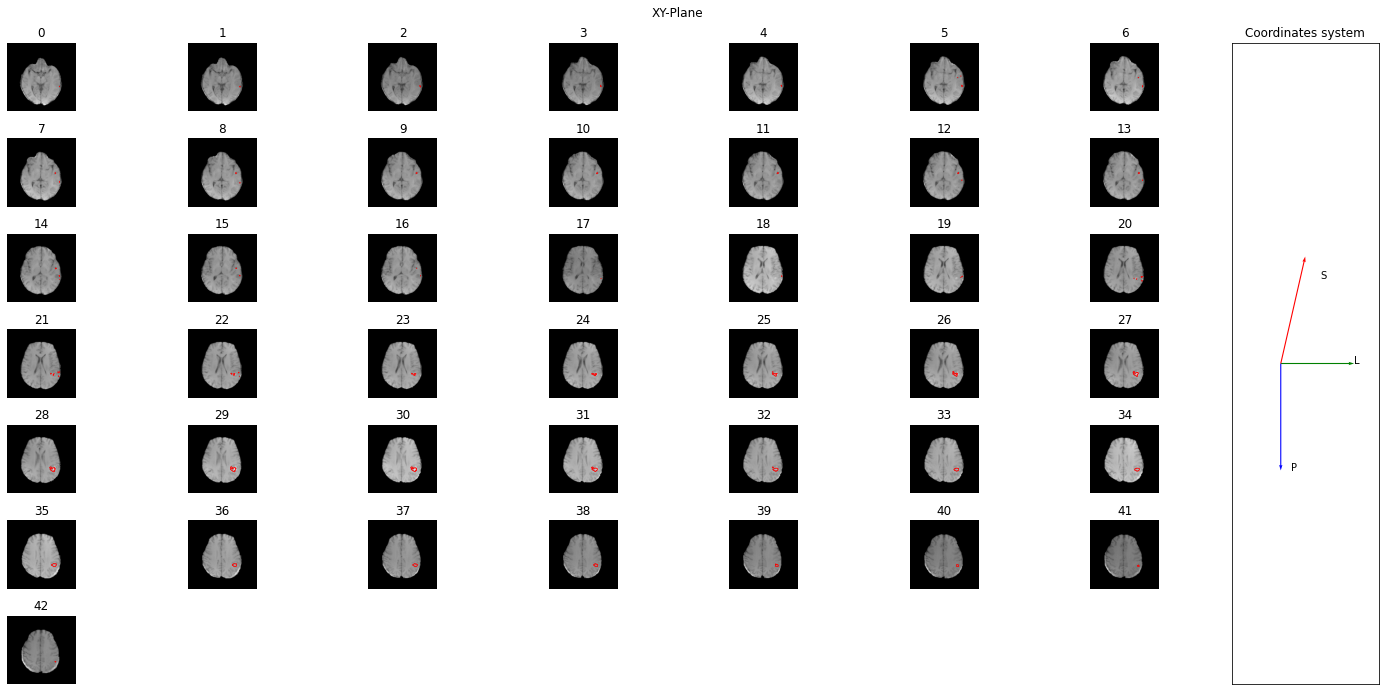

In [17]:
MEDimg.scan.display()

You can plot only one slice using the same method *display()* by specifying the index of the slice

<Figure size 432x288 with 0 Axes>

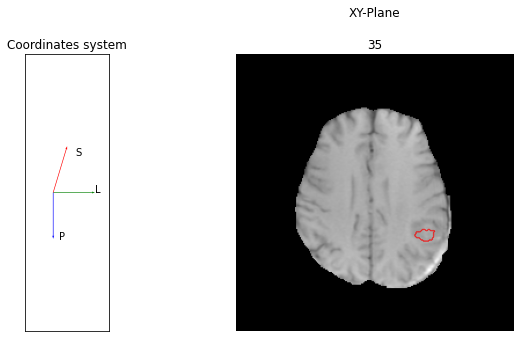

In [18]:
MEDimg.scan.display(35)

- *scanRot*: array of the rotation applied to the imaging data (if that's the case)

In [19]:
# scan rotation (usually None)
MEDimg.scan.volume.scanRot

- *spatialRef*: same functionality of [MATLAB imref3d class](https://www.mathworks.com/help/images/ref/imref3d.html).

Span of image in the x-dimension in the world coordinate system

In [20]:
MEDimg.scan.volume.spatialRef.ImageExtentInWorldX

240.0

Spatial Reference: Span of image in the y-dimension in the world coordinate system

In [21]:
MEDimg.scan.volume.spatialRef.ImageExtentInWorldY

240.0

Spatial Reference: Span of image in the z-dimension in the world coordinate system

In [22]:
MEDimg.scan.volume.spatialRef.ImageExtentInWorldZ

155.0

- **ROI** : A *scan* inner class that holds mask data and other information. It has the following attributes:
    - *indexes*: Dict of the ROI indexes for each ROI name.
    - *roi_names*: Dict of the ROI names for the imaging data.
    - *nameSet* (Not crucial for features extraction): Dict of the User-defined name for Structure Set for each ROI name.
    - nameSetInfo* (Not crucial for features extraction): Dict of the names of the structure sets that define the areas of significance. Either 'StructureSetName', 'StructureSetDescription', 'SeriesDescription' or 'SeriesInstanceUID'.

*indexes*: the indexes are just integers that point to the region of interest. For each ROI name we have a list of indexes. For our case we have 3 ROIs: *ED*, *ET* and *NET* so that makes three lists of ROI indexes. Let's see what that looks like in the code (we should have a *dict* of size 3)

In [23]:
MEDimg.scan.ROI.indexes

{'0': (array([5565983, 5565984, 5565985, ..., 6830775, 6830930, 6831086]),),
 '1': (array([5195371, 5195526, 5232100, ..., 6906568, 6906721, 6906722]),),
 '2': (array([5528627, 5528628, 5528629, ..., 6831540, 6831541, 6869197]),),
 '3': (array([5566137, 5566140, 5603182, ..., 6830775, 6830930, 6831086]),),
 '4': (array([5195371, 5195526, 5232100, ..., 6906568, 6906721, 6906722]),),
 '5': (array([5453918, 5454073, 5454228, ..., 6831540, 6831541, 6869197]),)}

As mentioned in the introduction, the ROI names are : *ED*, *ET* and *NET*, we must have the same names in our class instance, let's check...

In [24]:
MEDimg.scan.ROI.roi_names

{'0': 'ET', '1': 'NET', '2': 'ED', '3': 'ET_M', '4': 'NET_M', '5': 'ED_M'}

Finally, the two final attributes are *nameSet* and *nameSetInfo* are not used in any part of the code and are here for description.

In [25]:
MEDimg.scan.ROI.nameSet

{'0': '', '1': '', '2': '', '3': '', '4': '', '5': ''}

In [26]:
MEDimg.scan.ROI.nameSetInfo

{'0': 'SeriesDescription',
 '1': 'SeriesDescription',
 '2': 'SeriesDescription',
 '3': 'SeriesDescription',
 '4': 'SeriesDescription',
 '5': 'SeriesDescription'}

Let's try to change the value of some attributes, for example: we would like to change the ROI name for index *2*, which means we will replace *'NET'* with *'tumor'* 

In [27]:
MEDimg.scan.ROI.update_ROIname(2, 'tumor')
MEDimg.scan.ROI.roi_names

{'0': 'ET', '1': 'NET', '2': 'tumor', '3': 'ET_M', '4': 'NET_M', '5': 'ED_M'}

You can update every class attribute value using the right class methods for that (check the class diagram above)